# Dungeons & Data

This notebook focuses on accessing the [Dungeons & Dragons (Fifth Edition) API](https://www.dnd5eapi.co/) and exploring two questions about the monsters.

1. Are there any significant gaps in the monster coverage? Out of all the monsters available, are there niches in types, alignments, etc., that seem under-utilised?

2. Is there are clear relationship between monster stats and challenge rating? All monsters are assigned a challenge rating - essentially a difficulty level; it would be interesting to know to what extent the raw statistics of a monster link to its challenge level.

### Required libraries

In [2]:
import pandas as pd  # Manipulating data
import requests  # Accessing APIs
import seaborn as sns  # Visualisation
import matplotlib.pyplot as plt  # Visualisation
from textwrap import wrap  # Text formatting
from pandas.core.common import flatten  # Flatten lists of lists
from collections import Counter  # Count values
from sklearn.cluster import KMeans  # Clustering
from sklearn.preprocessing import scale  # Scaling data

### Set-up

In [3]:
# Standardise visualisations

sns.set()

## Data sourcing

In [4]:
# Get the full list of monsters from the api
monster_list = requests.get("http://dnd5eapi.co/api/monsters").json()
print(f"Found {monster_list['count']} monsters.")

Found 322 monsters.


In [5]:
# Holder for monster details
monster_details = []

# For each monster in the list,
for monster in monster_list["results"]:
    # Get the monster details
    url = f"http://www.dnd5eapi.co/api/monsters/{monster['index']}"
    details = requests.get(url).json()
    # And add them to the holder
    monster_details.append(details)

In [6]:
# Convert the list of results into a dataframe

monsters = pd.DataFrame(monster_details)

In [7]:
# View a random sample

monsters.sample(3)

,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,hit_dice,...,condition_immunities,senses,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds
42,5eb89d690b1bb138c5676451,behir,Behir,Huge,monstrosity,None,neutral evil,17,168,16d12,...,[],"{'darkvision': '90 ft.', 'passive_perception':...",Draconic,11.0,NaN,"[{'name': 'Multiattack', 'desc': 'The behir ma...",NaN,/api/monsters/behir,NaN,NaN
301,5eb89d690b1bb138c567655d,werewolf,Werewolf,Medium,humanoid,human,chaotic evil,11,58,9d8,...,[],{'passive_perception': 14},Common (can't speak in wolf form),3.0,"[{'name': 'Shapechanger', 'desc': 'The werewol...",[{'name': 'Multiattack (Humanoid or Hybrid For...,NaN,/api/monsters/werewolf,NaN,"[{'form': 'wolf', 'speed': {'walk': '40 ft.'}}]"
35,5eb89d690b1bb138c567644d,balor,Balor,Huge,fiend,demon,chaotic evil,19,262,21d12,...,"[{'name': 'Poisoned', 'url': '/api/conditions/...","{'truesight': '120 ft.', 'passive_perception':...","Abyssal, telepathy 120 ft.",19.0,"[{'name': 'Death Throes', 'desc': 'When the ba...","[{'name': 'Multiattack', 'desc': 'The balor ma...",NaN,/api/monsters/balor,NaN,NaN


In [8]:
# Check the dataframe size

monsters.shape

(322, 31)

In [9]:
monsters.columns

Index(['_id', 'index', 'name', 'size', 'type', 'subtype', 'alignment',
       'armor_class', 'hit_points', 'hit_dice', 'speed', 'strength',
       'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma',
       'proficiencies', 'damage_vulnerabilities', 'damage_resistances',
       'damage_immunities', 'condition_immunities', 'senses', 'languages',
       'challenge_rating', 'special_abilities', 'actions', 'legendary_actions',
       'url', 'reactions', 'other_speeds'],
      dtype='object')

## Data cleaning

In [10]:
# Drop columns that are API-,  rather than monster-related.

monsters.drop(["_id", "index", "url"], axis=1, inplace=True)

In [11]:
# Drop columns that are not required for this analysis

monsters = monsters[["name", "size", "type", "alignment", "armor_class",
                     "hit_points", "speed", "strength", "dexterity",
                     "constitution", "intelligence", "wisdom", "charisma",
                     "senses", "challenge_rating"]]

In [12]:
# Check for missing values in the overview

monsters.isna().sum()

name                0
size                0
type                0
alignment           0
armor_class         0
hit_points          0
speed               0
strength            0
dexterity           0
constitution        0
intelligence        0
wisdom              0
charisma            0
senses              0
challenge_rating    0
dtype: int64

## Data exploration

Text(0.5, 1.0, 'Monster counts by type')

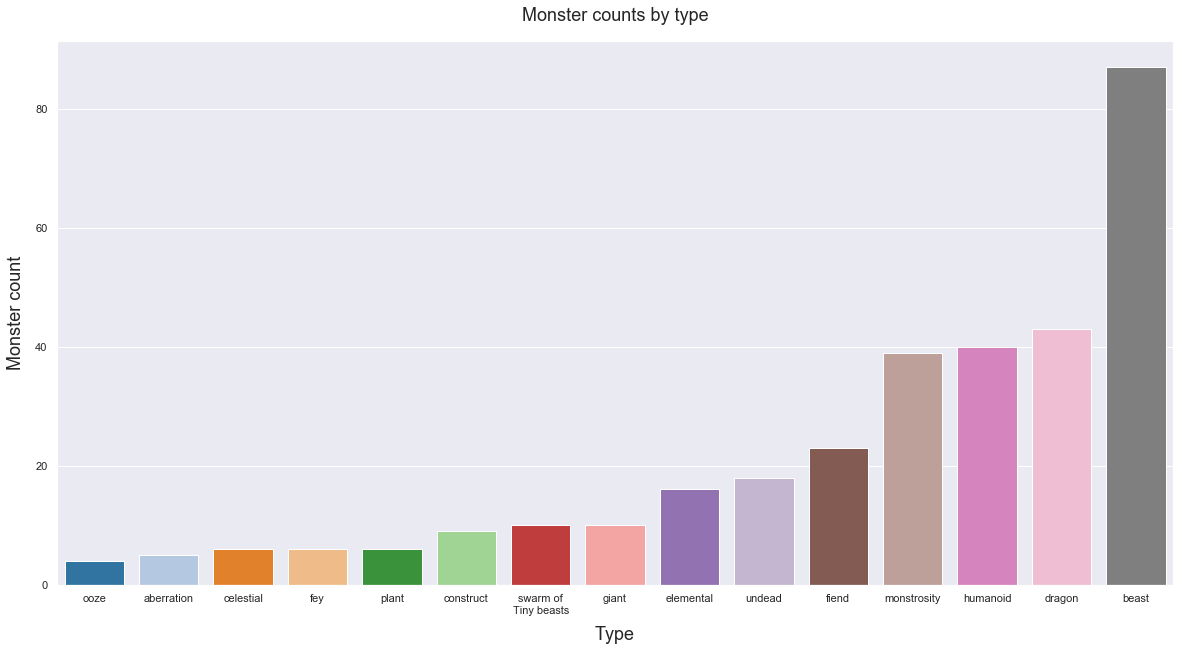

In [13]:
# Create a copy of the data for processing
vis_df = monsters.copy()
vis_df["type"] = vis_df["type"].apply(lambda x: "\n".join(wrap(x, 12)))

# Set the category names

plt.figure(figsize=(20,10))
plot = sns.countplot(vis_df["type"],
                     order= reversed(vis_df["type"].value_counts().index),
                     palette="tab20")
plot.set_ylabel("Monster count", fontsize=18, labelpad=10)
plot.set_xlabel("Type", fontsize=18, labelpad=10)
plot.set_title("Monster counts by type", fontsize=18, pad=20)

By far the most common type of monster is just "beast". Dragons are next, but this is because there are so many slightly-different types of dragon.

Celestial monsters seem comparatively rare compared to their fiendish counterparts.

Text(0.5, 1.0, 'Monster counts by size category')

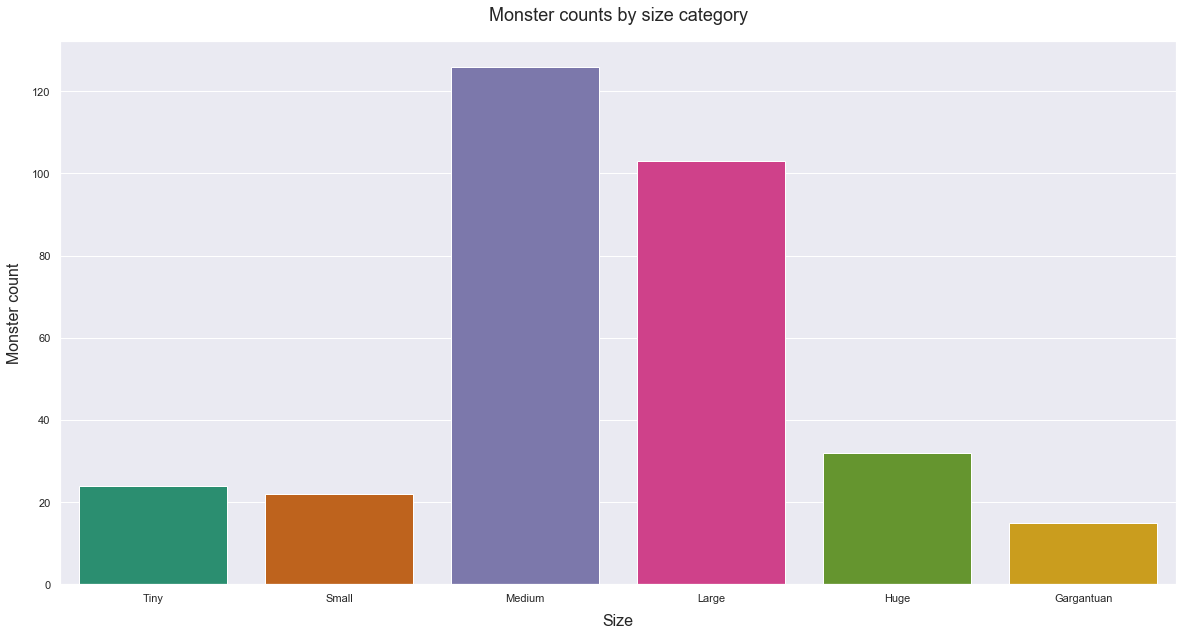

In [14]:
plt.figure(figsize=(20,10))
plot = sns.countplot(monsters["size"],
                     order=["Tiny", "Small", "Medium", "Large", "Huge", "Gargantuan"],
                     palette="Dark2")
plot.set_ylabel("Monster count", fontsize=16, labelpad=10)
plot.set_xlabel("Size", fontsize=16, labelpad=10)
plot.set_title("Monster counts by size category", fontsize=18, pad=20)

Text(0.5, 1, 'Monster numbers by alignment counts')

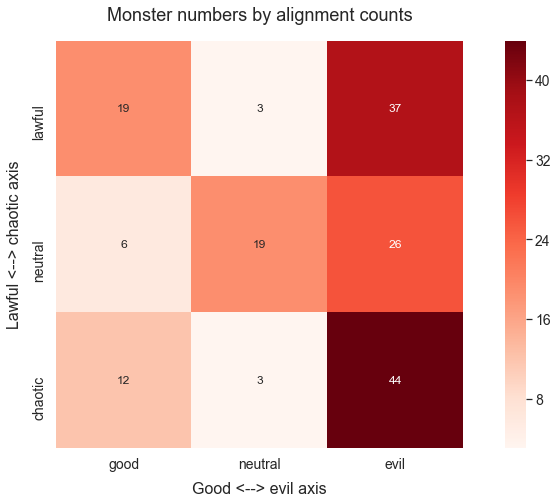

In [15]:
# Create a copy of the data for processing
vis_df = monsters.copy()

# Remove monsters with complicated alignments
vis_df = vis_df[~vis_df["alignment"].isin(["neutral good (50%) or neutral evil (50%)",
                                           "any non-lawful alignment",
                                           "any chaotic alignment",
                                           "any evil alignment",
                                           "any non-good alignment",
                                           "any alignment",
                                           "unaligned"])] 

# Create a morality column
vis_df["morality"] = vis_df["alignment"].apply(lambda x: "unaligned" if x == "unaligned"
                                               else "good" if "good" in x
                                               else "evil" if "evil" in x
                                               else "neutral")

# Create an outlook column
vis_df["outlook"] = vis_df["alignment"].apply(lambda x: "unaligned" if x == "unaligned"
                                              else "lawful" if "lawful" in x
                                              else "chaotic" if "chaotic" in x
                                              else "neutral")

# Create cross table and reorder it
vis_df = pd.crosstab(vis_df["morality"], vis_df["outlook"])
vis_df = vis_df[["lawful", "neutral", "chaotic"]].T[["good", "neutral", "evil"]]

# Visualise alignment combinations
plt.figure(figsize=(15, 7.5))
sns.set_context(rc={"xtick.labelsize":14,
                    "ytick.labelsize":14})
plot = sns.heatmap(vis_df, cmap="Reds", annot=True, square=True)
plot.set_ylabel("Lawful <--> chaotic axis", fontsize=16, labelpad=10)
plot.set_xlabel("Good <--> evil axis", fontsize=16, labelpad=10)
plot.set_title("Monster numbers by alignment counts", fontsize=18, pad=20)

As might reasonably be expected, evil monsters are the most common type. The most neglected niches though, aren't the good slots - neutral monsters are the least likely overall.

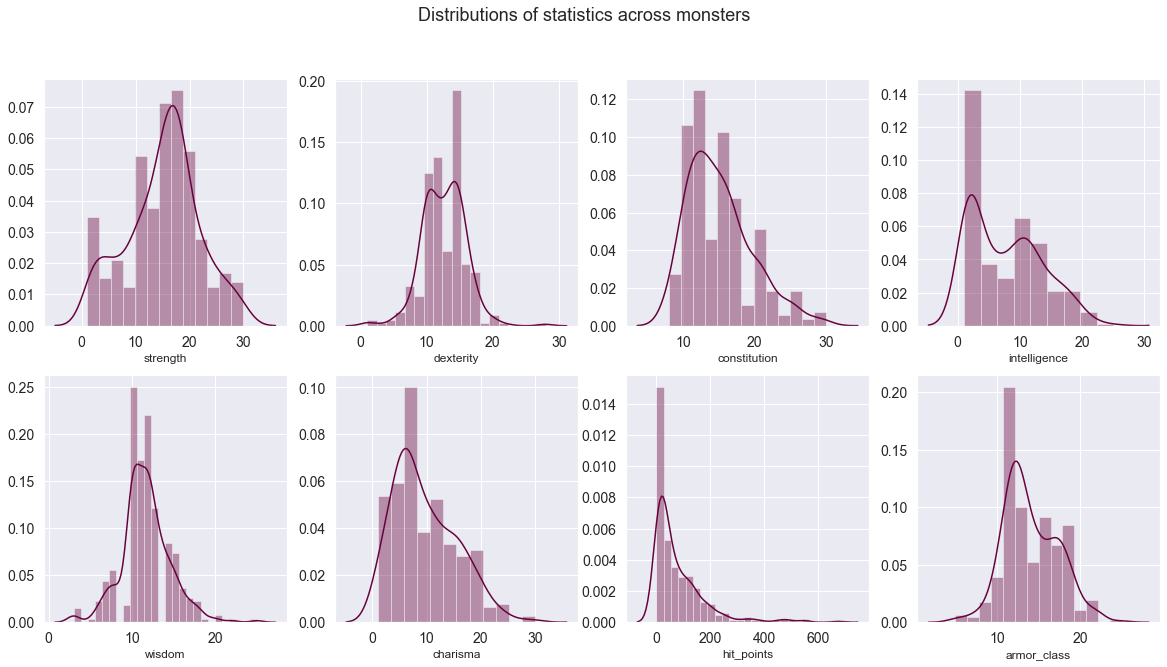

In [16]:
fig, plots = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle("Distributions of statistics across monsters", fontsize=18)
plots = list(flatten(plots))
stats = ["strength", "dexterity", "constitution", "intelligence", "wisdom", "charisma", "hit_points", "armor_class"]
for i in range(8):
    sns.distplot(monsters[stats[i]], ax=plots[i], color="#66023C")


The distributions suggest a couple of interesting things. Higher strengths seem to be more common with monsters than high intelligence or wisdom - a neglected type of monster might be the cerebral, rather than physical sort.

Hit points have the widest distribution by far, and operate on a completely different scale to the other stats.

## Senses and movement

Text(0.5, 1.0, 'Sense type by monster count')

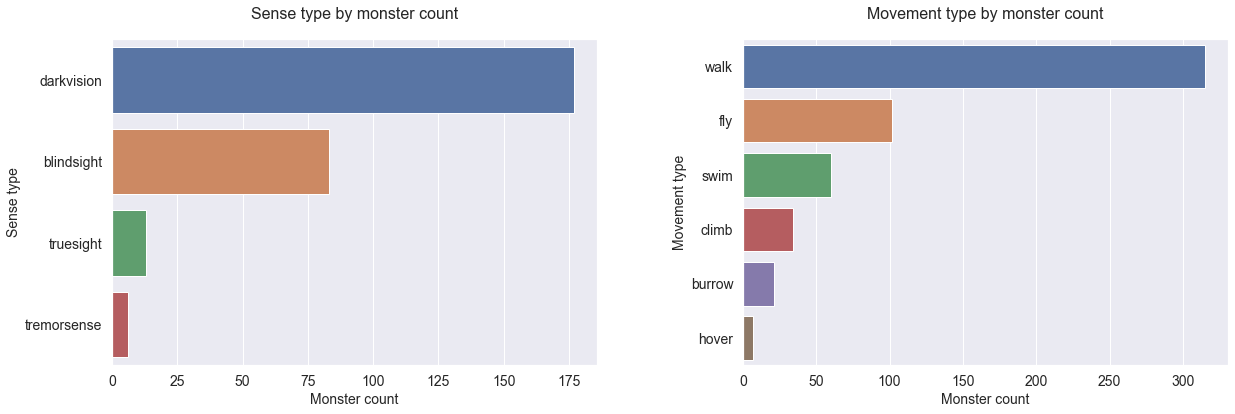

In [17]:
# Set up side-by-side plots

fig, plots = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)

# Count the monsters for each different kind of movement

movement = list(flatten(monsters["speed"].apply(lambda x: x.keys()).to_list()))

move_counts = Counter(movement)

move_counts = pd.Series(move_counts).sort_values(ascending=False)

# Plot the monster counts
plot = sns.barplot(x=move_counts, y=move_counts.index, ax=plots[1])
plot.set_ylabel("Movement type", fontsize=14)
plot.set_xlabel("Monster count", fontsize=14)
plot.set_title("Movement type by monster count", fontsize=16, pad=20)

# Count the monsters for each different kind of sense

senses = list(flatten(monsters["senses"].apply(lambda x: x.keys()).to_list()))

sense_counts = Counter(senses)

sense_counts = pd.Series(sense_counts).sort_values(ascending=False)

# Remove passive perception
del sense_counts["passive_perception"]

# Plot the monster counts
plot = sns.barplot(x=sense_counts, y=sense_counts.index, ax=plots[0])
plot.set_ylabel("Sense type", fontsize=14)
plot.set_xlabel("Monster count", fontsize=14)
plot.set_title("Sense type by monster count", fontsize=16, pad=20)

Burrowing and tremor sense are both rare amongst monsters. This clearly sugests an unfilled niche, as these two attributes are related, and would make sense together.

## Cluster monsters

I chose to use clustering to explore the relationship between challenge rating and other stats due to the small size of the dataset. This made regression impractical. In addition, challenge rating is not truly continuous - its a non-integer discrete ordinal variable, so numeric methods to predict it are less appropriate.

Clustering will give a good idea of which monsters are close together statistically, and those grouped monsters can then be compared in terms of challenge ratings, to see if they have similar scores.

In [18]:
# Create a dataframe to cluster on

cluster_df = monsters.copy()

# Choose only stat columns to cluster on

cluster_df = cluster_df[["strength", "dexterity", "constitution", "intelligence",
                         "wisdom", "charisma", "hit_points", "armor_class", "challenge_rating"]]

In [19]:
# Check types

cluster_df.dtypes

strength              int64
dexterity             int64
constitution          int64
intelligence          int64
wisdom                int64
charisma              int64
hit_points            int64
armor_class           int64
challenge_rating    float64
dtype: object

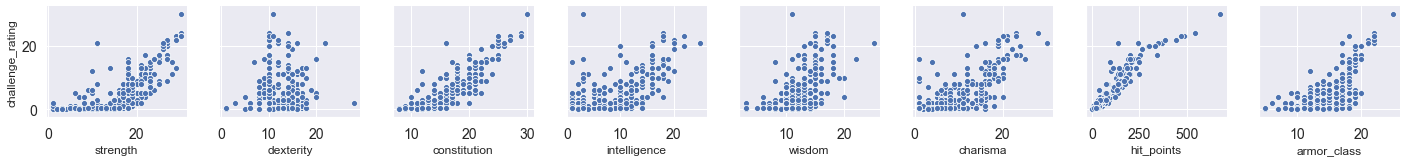

In [20]:
# Look for exciting correlations with challenge_rating

sns.pairplot(x_vars=cluster_df.drop("challenge_rating", axis=1).columns,
             y_vars="challenge_rating",
             data=cluster_df)

Text(0.5, 0, 'Hit points')

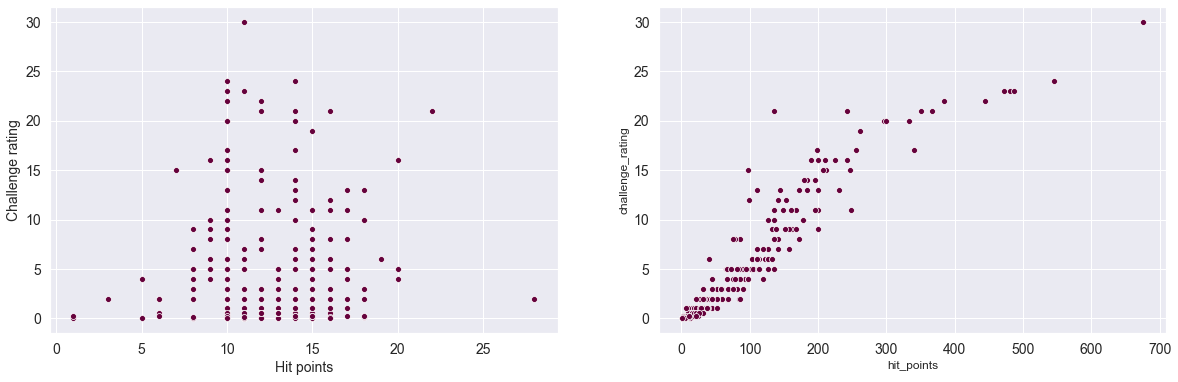

In [21]:
# Make the most interesting two plots larger

# Set up side-by-side plots

fig, plots = plt.subplots(1, 2, figsize=(20, 6))

# Build the scatterplots

plot = sns.scatterplot(y="challenge_rating", x="dexterity", data=monsters, ax=plots[0], color="#66023C")
plot.set_ylabel("Challenge rating", fontsize=14)
plot.set_xlabel("Dexterity", fontsize=14)

sns.scatterplot(y="challenge_rating", x="hit_points", data=monsters, ax=plots[1], color="#66023C")
plot.set_ylabel("Challenge rating", fontsize=14)
plot.set_xlabel("Hit points", fontsize=14)

Hit points are strongly correlated with increasing challenge rating - this suggests that one way used by the creators of DnD to increase monster difficulty is just to let monsters take more damage before death.

Interestingly, dexterity is much less strongly correlated, less so than any other statistic. I'm not sure why that would be the case.

In [21]:
# Remove the challenge rating column to actually cluster

cluster_df.drop("challenge_rating", axis=1, inplace=True)

# Scale the data - KMeans works by calculating averages, so without scaling, large values warp the clusters

scaled_cluster_df = scale(cluster_df)

In [22]:
# View the scaled data - now an NP array

scaled_cluster_df

array([[ 0.86803227, -1.13355851, -0.01794699, ...,  1.43874149,
         0.54102524,  0.91317706],
       [-0.76737747, -0.82078572, -1.12927963, ...,  0.22779178,
        -0.72822861, -1.23985756],
       [ 1.1653795 ,  0.43030542,  1.31565219, ...,  1.26574868,
         1.14543183,  1.52832981],
       ...,
       [ 1.1653795 , -0.82078572,  1.31565219, ...,  1.61173431,
         0.87344887,  1.22075343],
       [ 0.42201143, -0.82078572,  0.6488526 , ...,  0.4007846 ,
         0.52087835,  0.91317706],
       [-0.32135663, -2.07187687,  0.20431954, ..., -0.81016511,
        -0.59727384, -1.8550103 ]])

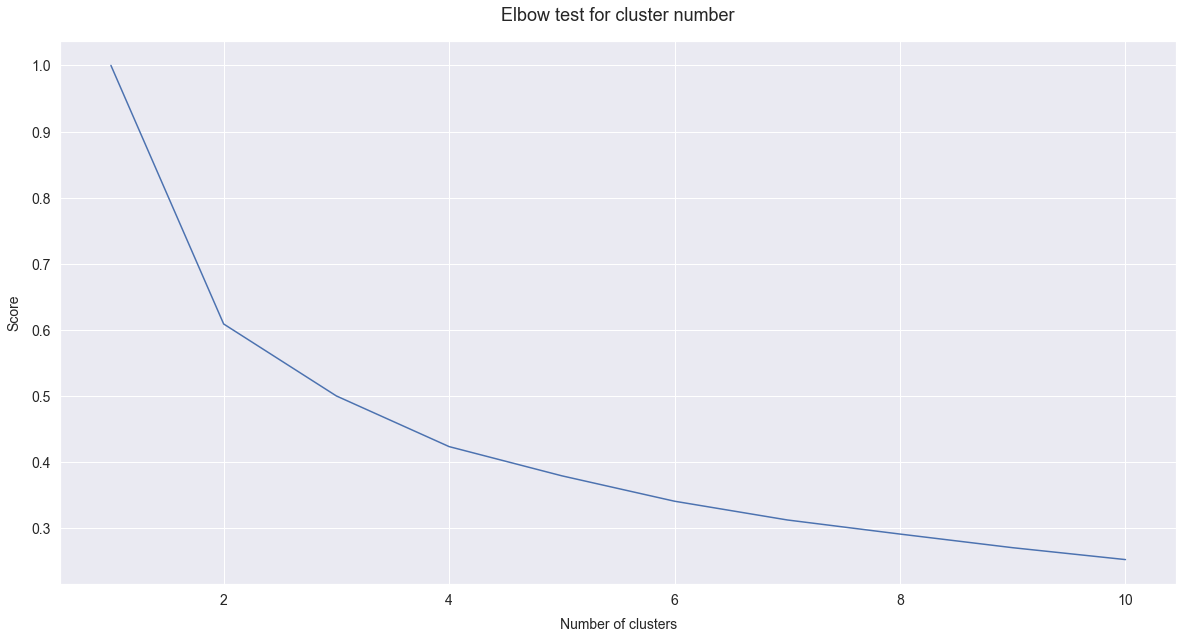

In [23]:
# Elbow test to find optimal clusters

# Generate models
K = [x for x in range(1, 11)]
models = [KMeans(n_clusters=K[x], random_state=451) for x in range(len(K))]

# Score models by inertia

scores = [models[i].fit(scaled_cluster_df).inertia_ for i in range(len(K))]

# Simplify the scores by dividing each one by the inertia of the model with 1 cluster only - the base error
# This forces the scores to be between 0 and 1, which makes things easier to read/interpret

scores = scores/scores[0]

# Plot the elbow test

plt.figure(figsize=(20,10))
plt.xlabel("Number of clusters", fontsize=14, labelpad=10)
plt.ylabel("Score", fontsize=14, labelpad=10)
plt.title("Elbow test for cluster number", fontsize=18, pad=20)
plot = sns.lineplot(K, scores)

Elbow tests are not mathematically-based - you simply choose the point where the slope starts to level out as the point at which you're not getting a large enough reduction in error for the loss of generalisability with each new cluster.

Based on this graph, I'm picking 6, as the last significant (albeit minor) slope change.

In [24]:
# Run k-means

cluster_results = KMeans(n_clusters=6, random_state=451).fit_predict(cluster_df)

# Add the clusters back onto the dataframe

monsters["cluster"] = cluster_results

## Evaluation

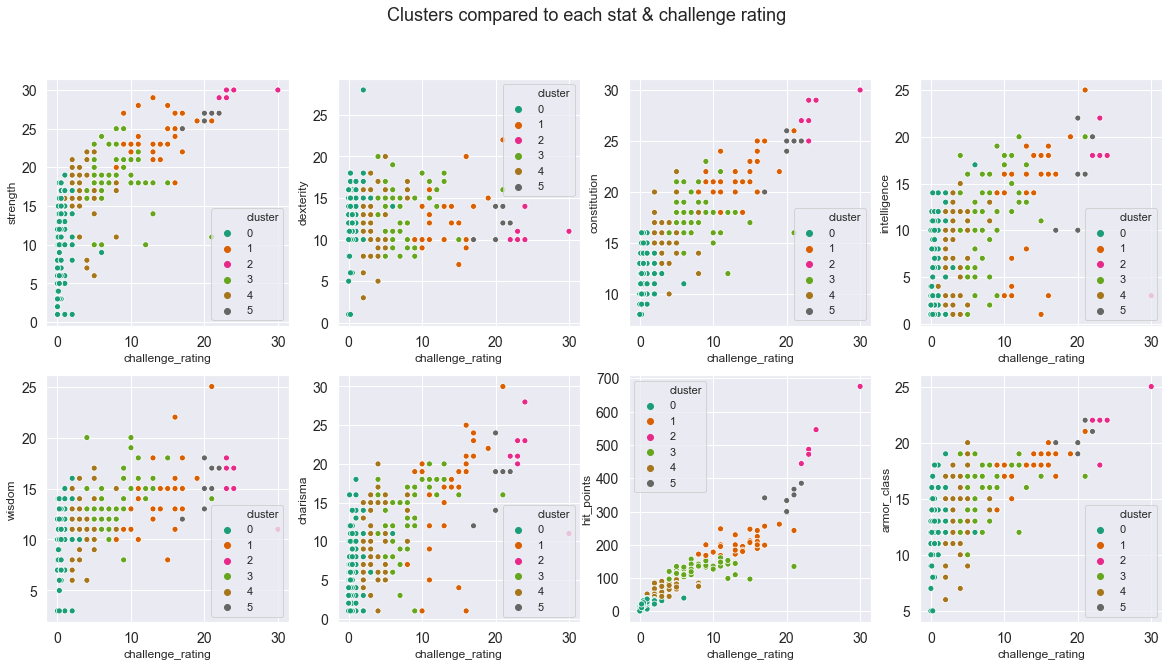

In [25]:
# Plot each stat against challenge rating, with the clusters as hue

fig, plots = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle("Clusters compared to each stat & challenge rating", fontsize=18)
plots = list(flatten(plots))

stats = ["strength", "dexterity", "constitution", "intelligence", "wisdom", "charisma", "hit_points", "armor_class"]
for i in range(8):
    sns.scatterplot(x="challenge_rating", y=stats[i], hue="cluster", data=monsters, ax=plots[i],
                    palette="Dark2", legend="full")

There's clear banding of the clusters along the x-axis as the challenge rating grows. This shows a relationship between the stats and the challenge rating, as the clusters are only based on the stats. 

Monsters with higher challenge ratings are clustered together; this was to be expected, as the different stats all showed some level of correlation with challenge rating, but the clusters combine all the stats together, suggesting the combination of stats is important.

This is particularly interesting when looking at dexterity, which did not on its own show a strong correlation with challenge rating. The clusters still separate into bands along the challenge rating axis.

Text(0.5, 1.0, 'Challenge rating vs. hit points, coloured by assigned cluster')

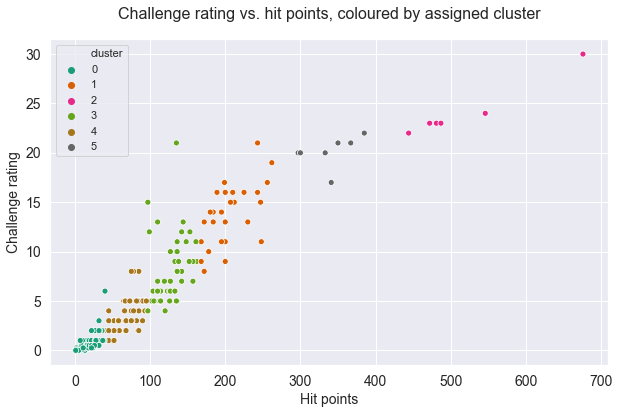

In [26]:
# Plot the most exciting one larger
plt.figure(figsize=(10,6))
plot = sns.scatterplot(y="challenge_rating", x="hit_points", hue="cluster", data=monsters, palette="Dark2", legend="full")
plot.set_ylabel("Challenge rating", fontsize=14)
plot.set_xlabel("Hit points", fontsize=14)
plot.set_title("Challenge rating vs. hit points, coloured by assigned cluster", fontsize=16, pad=20)

Broadly speaking, the clusters fall into bands across the x-axis, suggesting that challenge rating is relatively closely linked to stats. This is most noticeable with `hit_points`, implying the strongest link.

In [27]:
# For each cluster, output the number of monsters and CR stats

for cluster in sorted(monsters["cluster"].unique()):
    cluster_monsters = monsters[monsters["cluster"] == cluster]
    print(f"Cluster {cluster}: {cluster_monsters.shape[0]} monsters with an average CR of {round(cluster_monsters['challenge_rating'].mean(), 2)}")
    print(f"Max CR: {cluster_monsters['challenge_rating'].max()}. Min CR: {cluster_monsters['challenge_rating'].min()}")
    print("-" * 10)

Cluster 0: 153 monsters with an average CR of 0.58
Max CR: 6.0. Min CR: 0.0
----------
Cluster 1: 30 monsters with an average CR of 13.67
Max CR: 21.0. Min CR: 8.0
----------
Cluster 2: 7 monsters with an average CR of 24.14
Max CR: 30.0. Min CR: 22.0
----------
Cluster 3: 53 monsters with an average CR of 7.81
Max CR: 21.0. Min CR: 4.0
----------
Cluster 4: 72 monsters with an average CR of 3.33
Max CR: 8.0. Min CR: 1.0
----------
Cluster 5: 7 monsters with an average CR of 20.14
Max CR: 22.0. Min CR: 17.0
----------


In [28]:
# Create a summary dataframe

summary_df = monsters.groupby("cluster").agg({"name": "count", "challenge_rating": ["mean", "min", "max"]})

In [29]:
# Simplify the columns

summary_df.columns = ["monster_count", "mean_challenge_rating",
                      "min_challenge_rating", "max_challenge_rating"]


# Round the values

summary_df = summary_df.round(2)

In [30]:
# Sort by challenge_rating mean

summary_df.sort_values(by="mean_challenge_rating", inplace=True)

In [31]:
summary_df

,monster_count,mean_challenge_rating,min_challenge_rating,max_challenge_rating
cluster,,,,
0,153,0.58,0.0,6.0
4,72,3.33,1.0,8.0
3,53,7.81,4.0,21.0
1,30,13.67,8.0,21.0
5,7,20.14,17.0,22.0
2,7,24.14,22.0,30.0
